In [2]:
from sentence_transformers import SentenceTransformer, util
from fuzzywuzzy import fuzz
from Levenshtein import jaro
import statistics
import pymongo
from transformers import pipeline
import nltk
from rouge import Rouge
import spacy
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt
import numpy as np
from keybert import KeyBERT
from multi_rake import Rake
import yake
import warnings
import json
from statsmodels.stats.multicomp import pairwise_tukeyhsd


# Reading the necessary Keys

In [3]:
file_path = '../keys.json'
target_key = 'mongo_path'
with open(file_path, 'r') as file:
    data = json.load(file)
cluster_path = data.get(target_key)
if cluster_path is None:
    print(f"Cluster Path found")


## Mongo DB Initializations

In [4]:
# Supress warnings
warnings.filterwarnings("ignore")

# Establish a connection to the MongoDB cluster
cluster = pymongo.MongoClient(cluster_path)

# Connect to a specific database
db = cluster["DialoKEY"]

# Read a document from a collection
collection = db["logs_04"]
collection_cleaned = db["logs_cleaned_3"]
document = collection.find_one()

## Creating some variables


In [5]:
all_documents = []
length_history = []

punished_eval = {
    "FT - HQ": {},
    "FT - CR": {},
    "FT - XL": {},
    "STOCK - 1": {},
    "STOCK - 2": {}
}

all_models = [
    "FT - HQ",
    "FT - CR",
    "FT - XL",
    "STOCK - 1",
    "STOCK - 2"
]

different_scenarios = [
    {"string": "Question: Hello, this is Giovanni's Pizza and Pasta Restaurant, how can we help you?",
     "scenario": 1,
     "type": "defined"},
    {"string": "Question: Hello at Cutting Edges Hairdresser, what can I do for you?",
     "scenario": 2,
     "type": "defined"},
    {"string": "Question: Hi! Let's chat about hobbies. What is yours?",
     "scenario": 3,
     "type": "open"},
    {"string": "Question: Welcome to the Restaurant Tikka on Wheels. How can I help you?",
     "scenario": 4,
     "type": "defined"},
    {"string": "Question: Hello and welcome to the Wheely Great Car Repair Shop. What's wrong with your car?",
     "scenario": 5,
     "type": "open"},
    {"string": "Question: Welcome to Dr. Peppers Medical Clinic. I am Lisa, what can I do for you?",
     "scenario": 6,
     "type": "open"},
    {"string": "Question: This is the Mississippi online shop customer service. How can I help you?",
     "scenario": 7,
     "type": "defined"},
    {"string": "Question: Long time no speak, how are you doing?",
     "scenario": 8,
     "type": "open"}
]

In [6]:
def clear_values():
    ratings = ({"HUMAN": [],
                "BERT": [],
                "FUZZ": [],
                "JARO": [],
                "BLEU": [],
                "METEOR": [],
                "ROUGE": [],
                "SPACY": []})

    keywords = ({"KeyBERT": [],
                 "YAKE (Detailed)": [],
                 "YAKE": [],
                 "RAKE": [],
                 "HUMAN": []})

    length_history = []

    for model in all_models:
        punished_eval[model]["rating"] = 0
        punished_eval[model]["rating_punished"] = 0
        punished_eval[model]["amount"] = 0
        punished_eval[model]["amount_punished"] = 0
        punished_eval[model]["good"] = 0
        punished_eval[model]["okay"] = 0
        punished_eval[model]["bad"] = 0
        punished_eval[model]["worst"] = 0
        punished_eval[model]["perfect"] = 0
        punished_eval[model]["length_answer_created"] = 0
        punished_eval[model]["length_answers_human"] = 0
        punished_eval[model]["length_keywords"] = 0
        punished_eval[model]["FUZZ"] = 0
        punished_eval[model]["JARO"] = 0
        punished_eval[model]["HUB"] = 0
        punished_eval[model]["BERT"] = 0
        punished_eval[model]["keywords_in_creation"] = 0
        punished_eval[model]["keywords_in_creation_human"] = 0
        punished_eval[model]["counter_no_rating"] = 0
        punished_eval[model]["ratings"] = ratings
        punished_eval[model]["keywords"] = {}


## Sentence Similarity

### Downloading Models

In [7]:
# Initializing the models
model_bert = SentenceTransformer('all-MiniLM-L6-v2')
classifier = pipeline("zero-shot-classification")
nltk.download('wordnet')
spacy.cli.download("en_core_web_lg")
nlp = spacy.load('en_core_web_lg')
kw_model = KeyBERT(model='all-mpnet-base-v2')

No model was supplied, defaulted to facebook/bart-large-mnli and revision c626438 (https://huggingface.co/facebook/bart-large-mnli).
Using a pipeline without specifying a model name and revision in production is not recommended.
[nltk_data] Downloading package wordnet to /Users/lucas/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 587.7/587.7 MB 2.9 MB/s eta 0:00:0000:0100:01
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_lg')


### Defining a function for all similarity tools

In [8]:
def sentence_comparison(sent1, sent2, bool):
    # Embeddings
    sent1 = sent1.lower()
    sent2 = sent2.lower()
    em_1 = model_bert.encode(sent1)
    em_2 = model_bert.encode(sent2)

    # COSINE SIMILARIY Scores
    sim_bert = util.cos_sim(em_1, em_2).item()
    sim_fuzz = fuzz.ratio(sent1, sent2)
    sim_jaro = jaro(sent1, sent2)

    # Image Captioning / Translation Scores
    reference = sent1.split()
    hypothesis = sent2.split()
    sim_bleu = nltk.translate.bleu_score.sentence_bleu([reference], hypothesis, weights=(1, 0, 0, 0))
    sim_meteor = nltk.translate.meteor_score.meteor_score([reference], hypothesis)
    rouge = Rouge()
    if sent2 == "" or sent1 == "":
        sim_rouge = 0
    else:
        sim_rouge = rouge.get_scores(sent1, sent2)[0]['rouge-1']['f']
    sim_spacy = nlp(sent1).similarity(nlp(sent2))

    # Check if keywords should be compared or sentences
    if not bool:
        scores = ({"BERT": sim_bert,
                   "FUZZ": sim_fuzz / 100,
                   "JARO": sim_jaro,
                   "BLEU": sim_bleu,
                   "METEOR": sim_meteor,
                   "ROUGE": sim_rouge,
                   "SPACY": sim_spacy})
        return scores
    else:
        keywords_given = sent1
        keywords_created = sent2
        created_in_given = 0
        given_in_created = 0
        for keywords in keywords_created.split():
            if keywords.lower() in keywords_given.lower().split():
                created_in_given += 1

        for keywords in keywords_given.split():
            if keywords.lower() in keywords_created.lower().split():
                given_in_created += 1

        if keywords_given == "" or keywords_created == "":
            score_classifier_given_created = 0
            score_classifier_created_given = 0
        else:
            results_score_classifier_given_created = classifier(keywords_given, keywords_created, multi_label=True)
            results_score_classifier_created_given = classifier(keywords_created, keywords_given, multi_label=True)
            score_classifier_created_given = statistics.mean(results_score_classifier_created_given['scores'])
            score_classifier_given_created = statistics.mean(results_score_classifier_given_created['scores'])

        if len(keywords_created.split()) == 0:
            score_created_in_given = 0
        else:
            score_created_in_given = created_in_given / len(keywords_created.split())

        if len(keywords_given.split()) == 0:
            score_given_in_created = 0
        else:
            score_given_in_created = given_in_created / len(keywords_given.split())

        scores = ({
            "score_created_in_given": score_created_in_given,
            "score_given_in_created": score_given_in_created,
            "score_classifier_created_given": score_classifier_created_given,
            "score_classifier_given_created": score_classifier_given_created,
            "BERT": sim_bert,
            "FUZZ": sim_fuzz / 100,
            "JARO": sim_jaro,
            "BLEU": sim_bleu,
            "METEOR": sim_meteor,
            "ROUGE": sim_rouge,
            "SPACY": sim_spacy
        })
        return scores

In [9]:
# Topic Analysis via Zero Short Learning
def keywords_in_creation(sentence, keywords):
    results = classifier(sentence, keywords, multi_label=True)
    return statistics.mean(results['scores'])


# Keyword Extraction

In [10]:
def kw_yake(text):
    language = "en"
    max_ngram_size = 1
    deduplication_threshold = 0.9
    numOfKeywords = 10
    custom_kw_extractor = yake.KeywordExtractor(lan=language, n=max_ngram_size, dedupLim=deduplication_threshold,
                                                top=numOfKeywords, features=None)
    keywords = custom_kw_extractor.extract_keywords(text)
    keywords_str = ""
    for index, keyword in enumerate(keywords):
        if index == len(keywords) - 1:
            keywords_str += f"{keyword[0]}"
        else:
            keywords_str += f"{keyword[0]} "
    return keywords_str


def kw_yake_detailed(text):
    language = "en"
    max_ngram_size = 5
    deduplication_threshold = 0.0
    numOfKeywords = 10
    custom_kw_extractor = yake.KeywordExtractor(lan=language, n=max_ngram_size, dedupLim=deduplication_threshold,
                                                top=numOfKeywords, features=None)
    keywords = custom_kw_extractor.extract_keywords(text)
    keywords_str = ""
    for index, keyword in enumerate(keywords):
        if index == len(keywords) - 1:
            keywords_str += f"{keyword[0]}"
        else:
            keywords_str += f"{keyword[0]} "
    return keywords_str


def kw_rake(text):
    rake = Rake()
    keywords = rake.apply(text)
    keywords_str = ""
    for index, keyword in enumerate(keywords):
        if index == len(keywords) - 1:
            keywords_str += f"{keyword[0]}"
        else:
            keywords_str += f"{keyword[0]} "
    return (keywords_str)


def kw_keybert(text):
    keywords = kw_model.extract_keywords(
        text,
        keyphrase_ngram_range=(1, 7),
        stop_words='english',
        highlight=False,
        top_n=1)
    keywords_list = list(dict(keywords).keys())
    if not keywords_list:
        return ""
    return (keywords_list[0])


def keyword_extractors(text):
    keywords = [
        {"model": "KeyBERT",
         "kws": kw_keybert(text)},
        {"model": "YAKE",
         "kws": kw_yake(text)},
        {"model": "YAKE (Detailed)",
         "kws": kw_yake_detailed(text)},
        {"model": "RAKE",
         "kws": "kw_rake(text)"}
    ]
    return keywords

# Collecting data from mongodb and inserting evaluation metrics

In [11]:
cursor3 = collection_cleaned.find({})
length = len(list(cursor3.clone()))
clear_values()
# Handled with care, code takes approximately 1-2h to run
# The data must be cleaned before with the cleaning_data code
read_new_data = False

if read_new_data:
    # Iterating over database documents
    for count, document in enumerate(cursor3):
        print(f"STATUS: {float(((count + 1) / length) * 100)} %")

        # If no status message
        if "final_code" not in document:
            for i in different_scenarios:
                if i['string'] in document['Question']:
                    collection_cleaned.update_many({'_id': document['_id']}, {"$set": {'eval_scenario': i}}, True)
                    break

            # Check if the document is an answer
            if document['User Flag'] == "":
                punished_eval[document['Chosen Model']]['counter_no_rating'] += 1
                keywords = document['Keyword (human)'].split()
                answer_human = document['Answers']['Human Answer']
                answer_created = document['Answers']['Answer Created']
                keywords_raw = document['Keyword (human)']

                length_keywords = len(keywords)
                length_answer_created = len(answer_created.split())
                length_answers_human = len(answer_human.split())

                # Check if a valid answer was entered by the human
                if length_keywords > length_answers_human:
                    print("+++ Skipped File, Answer was Empty or shorter than kws+++")
                    continue

                # Evaluation of keywords and sentences
                eval_length = {
                    "length_human_answer": len(answer_human.split()),
                    "length_created_answer": len(answer_created.split()),
                    "length_keywords": len(keywords),
                }
                collection_cleaned.update_many({'_id': document['_id']}, {"$set": {'eval_length': eval_length}}, True)

                # Keywords in Creation
                eval_keywords_in_creation = {}
                eval_keywords_in_creation['keywords_in_creation'] = keywords_in_creation(answer_created, keywords)
                eval_keywords_in_creation['keywords_in_creation_human'] = keywords_in_creation(answer_human, keywords)
                collection_cleaned.update_many({'_id': document['_id']},
                                               {"$set": {'eval_keywords_in_creation': eval_keywords_in_creation}}, True)

                # Keyword Comparison
                answer_cleaned = answer_human.replace("\"", "").replace("’", "'").replace("–", "-").replace("“",
                                                                                                            "\"").replace(
                    " ", " ").replace("“", "\n").replace("é", "é").replace("  ", " ").replace("…", "...").replace("‘",
                                                                                                                  "'").replace(
                    "é", "é")
                keywords_to_insert = keyword_extractors(str(answer_cleaned))
                keywords_to_insert.append({"model": "HUMAN",
                                           "kws": keywords_raw})
                for x in keywords_to_insert:
                    x['ratings'] = sentence_comparison(keywords_raw, x['kws'], True)
                collection_cleaned.update_many({'_id': document['_id']},
                                               {"$set": {'eval_different_keywords': keywords_to_insert}}, True)
            # Document is rating
            elif "Perfect" in document['User Flag']:
                answer_human = document['Answers']['Human Answer']
                answer_created = document['Answers']['Answer Created']
                similarity_scores = sentence_comparison(answer_created, answer_human, False)
                similarity_scores['HUMAN'] = 5
                similarity_scores['HUMAN (Punished)'] = 5
                collection_cleaned.update_many({'_id': document['_id']},
                                               {"$set": {'eval_similarity': similarity_scores}},
                                               True)
                collection_cleaned.update_many({'_id': document['_id']},
                                               {"$set": {'eval_similarity': similarity_scores}},
                                               True)
            else: # Rating is not perfect
                punishment = 1
                rating = 0
                if not document['User Flag Detailed']:
                    continue

                if "Slightly" in document['User Flag Detailed']:
                    punishment = 1
                    detailed_rating = 1
                elif "brief" in document['User Flag Detailed']:
                    punishment = 0.9
                    detailed_rating = 2
                elif "Missed" in document['User Flag Detailed']:
                    punishment = (2 / 3)
                    detailed_rating = 3
                elif "Added" in document['User Flag Detailed']:
                    punishment = 0.5
                    detailed_rating = 4
                elif "Wrong" in document['User Flag Detailed']:
                    punishment = 0.25
                    detailed_rating = 5
                elif "Totally" in document['User Flag Detailed']:
                    punishment = 0.1
                    detailed_rating = 6

                if "Good" in document['User Flag']:
                    punished_eval[document['Chosen Model']]['good'] += 1
                    rating = 4
                    punished_rating = punishment * rating
                elif "Bad" in document['User Flag']:
                    punished_eval[document['Chosen Model']]['bad'] += 1
                    rating = 2
                    punished_rating = punishment * rating
                elif "Wrong" in document['User Flag']:
                    punished_eval[document['Chosen Model']]['worst'] += 1
                    rating = 1
                    punished_rating = punishment * rating
                else:
                    punished_eval[document['Chosen Model']]['okay'] += 1
                    rating = 3
                    punished_rating = punishment * rating

                answer_human = document['Answers']['Human Answer']
                answer_created = document['Answers']['Answer Created']
                similarity_scores = sentence_comparison(answer_created, answer_human, False)
                similarity_scores['HUMAN'] = rating
                similarity_scores['HUMAN (Punished)'] = punished_rating
                similarity_scores['HUMAN (Detailed)'] = detailed_rating
                collection_cleaned.update_many({'_id': document['_id']},
                                               {"$set": {'eval_similarity': similarity_scores}},
                                               True)


# Reading the metrics of the cleaned db

In [12]:
# The evaluation metrics need to be inserted if new data is added
# Otherwise lots of the parameters lead to an error since they are not available in the data
cursor4 = collection_cleaned.find({})

# Creating all variables for all evaluation scores
# This section is very specific to the datastructure of the saved elements
all_classifiers = ["score_created_in_given",
                   "score_given_in_created",
                   "score_classifier_created_given",
                   "score_classifier_given_created",
                   "BERT",
                   "FUZZ",
                   "JARO",
                   "BLEU",
                   "METEOR",
                   "ROUGE",
                   "SPACY"
                   ]

all_keyword_methods = ["KeyBERT", "YAKE", "YAKE (Detailed)", "HUMAN"]

keywords_eval = ({"KeyBERT": {},
                  "YAKE": {},
                  "YAKE (Detailed)": {},
                  "HUMAN": {}})
for classifiers in all_classifiers:
    for keyword_method in all_keyword_methods:
        keywords_eval[keyword_method][classifiers] = []

eval_length_inside = ["length_human_answer",
                      "length_created_answer",
                      "length_difference",
                      "length_keywords"]

eval_length = {}
for model in all_models:
    eval_length[model] = {}
    for eval in eval_length_inside:
        eval_length[model][eval] = []

eval_keywords_in_creation_inside = [
    "keywords_in_creation",
    "keywords_in_creation_human"
]
eval_keywords_in_creation = {}
for model in all_models:
    eval_keywords_in_creation[model] = {}
    for eval in eval_keywords_in_creation_inside:
        eval_keywords_in_creation[model][eval] = []

eval_runtime = {}
for model in all_models:
    eval_runtime[model] = []

evaluation_answer = {
    'keywords_eval': keywords_eval
}

ratings = ["HUMAN",
           "HUMAN (Punished)",
           "BERT",
           "FUZZ",
           "JARO",
           "BLEU",
           "METEOR",
           "ROUGE",
           "SPACY"]

similarity_scores = {}
for model in all_models:
    similarity_scores[model] = {}
    for rate in ratings:
        similarity_scores[model][rate] = []

similarity_scores_all_models = {}
for rate in ratings:
    similarity_scores_all_models[rate] = []

detailed = {}
for model in all_models:
    similarity_scores[model] = {}
    for rate in ratings:
        similarity_scores[model][rate] = []

similarity_scores_perfect = {}
for rate in ratings:
    similarity_scores_perfect[rate] = []

ratings2 = ["HUMAN",
            "HUMAN (Punished)"]

different_lengths = ["2",
                     "4",
                     "6",
                     "8"]

length_compared_to_scores = {}
for model in all_models:
    length_compared_to_scores[model] = {}
    for length in different_lengths:
        length_compared_to_scores[model][length] = {}
        for rate in ratings2:
            length_compared_to_scores[model][length][rate] = []

number_of_keywords = ["0",
                      "1",
                      "2",
                      "3",
                      "4",
                      "5"
                      ]

rating_compared_to_amount_keywords = {}
for model in all_models:
    rating_compared_to_amount_keywords[model] = {}
    for length in number_of_keywords:
        rating_compared_to_amount_keywords[model][length] = {}
        for rate in ratings2:
            rating_compared_to_amount_keywords[model][length][rate] = []

different_scenario_numbers = ["1",
                              "2",
                              "3",
                              "4",
                              "5",
                              "6",
                              "7",
                              "8"
                              ]

rating_compared_scenarios_all = {}
for model in all_models:
    rating_compared_scenarios_all[model] = {}
    for number in different_scenario_numbers:
        rating_compared_scenarios_all[model][number] = {}
        for rate in ratings2:
            rating_compared_scenarios_all[model][number][rate] = []

different_scenario_type = ["open",
                           "defined"
                           ]

rating_compared_scenarios_open_closed = {}
for model in all_models:
    rating_compared_scenarios_open_closed[model] = {}
    for scenario_type in different_scenario_type:
        rating_compared_scenarios_open_closed[model][scenario_type] = {}
        for rate in ratings2:
            rating_compared_scenarios_open_closed[model][scenario_type][rate] = []

rating_in_numbers = ["1",
                     "2",
                     "3",
                     "4",
                     "5"
                     ]

rating_compared_detailed_rating = {}
for model in all_models:
    rating_compared_detailed_rating[model] = {}
    for number in rating_in_numbers:
        rating_compared_detailed_rating[model][number] = []

detailed_ratings_per_model = {}
for model in all_models:
    detailed_ratings_per_model[model] = []

length_of_prompts = {}
for model in all_models:
    length_of_prompts[model] = []

# Prompt length
prompts_of_models = {
    "FT - HQ": "",
    "FT - CR": "",
    "FT - XL": "",
    "STOCK - 1": "Create an answer based on the given keywords and the question:",
    "STOCK - 2": "The following is a telephone conversation. Write one sentence as the next response using the keywords: {keyword}. Do not any additional details."
}

#Latency
latency = {}
for model in all_models:
    latency[model] = []

# Iterating over the cleaned database including all evaluation elements
for count, document in enumerate(cursor4):
    # Answer
    if document['User Flag'] == "":
        keywords = document['Keyword (human)'].split()
        answer_human = document['Answers']['Human Answer']
        answer_created = document['Answers']['Answer Created']
        keywords_raw = document['Keyword (human)']

        length_keywords = len(keywords)
        length_answer_created = len(answer_created.split())
        length_answers_human = len(answer_human.split())

        if length_keywords > length_answers_human:
            print("+++ Skipped File, Answer was Empty or shorter than kws+++")
            continue
        eval_length[document['Chosen Model']]['length_human_answer'].append(
            document['eval_length']['length_human_answer'])
        eval_length[document['Chosen Model']]['length_created_answer'].append(
            document['eval_length']['length_created_answer'])
        eval_length[document['Chosen Model']]['length_keywords'].append(document['eval_length']['length_keywords'])
        eval_keywords_in_creation[document['Chosen Model']]['keywords_in_creation'].append(
            document['eval_keywords_in_creation']['keywords_in_creation'])
        eval_keywords_in_creation[document['Chosen Model']]['keywords_in_creation_human'].append(
            document['eval_keywords_in_creation']['keywords_in_creation_human'])

        eval_runtime[document['Chosen Model']].append(document['Runtime'])

        list_of_strings = document['Question']

        combined_string = ""
        for word in list_of_strings:
            combined_string += word + " "
        combined_string += document['Keyword (human)']
        combined_string += prompts_of_models[document['Chosen Model']]
        # remove the extra space
        combined_string = combined_string.strip()

        # count the words in the combined string
        word_count = len(combined_string.split())
        length_of_prompts[document['Chosen Model']].append(word_count)

        # Keyword Evaluation
        if not 'eval_different_keywords' in document:
            break
        for o in document['eval_different_keywords']:
            if o['model'] == 'RAKE':
                continue

            for classifier in all_classifiers:
                keywords_eval[o['model']][classifier].append(o['ratings'][classifier])
    # Question
    else:
        if len(document['Keyword (human)'].split()) > 4:
            position = '5'
        else:
            position = str(len(document['Keyword (human)'].split()))
        rating_compared_to_amount_keywords[document['Chosen Model']][position]['HUMAN'].append(
            document['eval_similarity']['HUMAN'])
        rating_compared_to_amount_keywords[document['Chosen Model']][position]['HUMAN (Punished)'].append(
            document['eval_similarity']['HUMAN (Punished)'])
        length_compared_to_scores[document['Chosen Model']][str(len(document['Question']))]['HUMAN'].append(
            document['eval_similarity']['HUMAN'])
        length_compared_to_scores[document['Chosen Model']][str(len(document['Question']))]['HUMAN (Punished)'].append(
            document['eval_similarity']['HUMAN (Punished)'])
        rating_compared_scenarios_open_closed[document['Chosen Model']][document['eval_scenario']['type']][
            'HUMAN'].append(document['eval_similarity']['HUMAN'])
        rating_compared_scenarios_open_closed[document['Chosen Model']][document['eval_scenario']['type']][
            'HUMAN (Punished)'].append(document['eval_similarity']['HUMAN (Punished)'])
        rating_compared_scenarios_all[document['Chosen Model']][str(document['eval_scenario']['scenario'])][
            'HUMAN'].append(document['eval_similarity']['HUMAN'])
        rating_compared_scenarios_all[document['Chosen Model']][str(document['eval_scenario']['scenario'])][
            'HUMAN (Punished)'].append(document['eval_similarity']['HUMAN (Punished)'])
        if not document['eval_similarity']['HUMAN'] == 5:
            rating_compared_detailed_rating[document['Chosen Model']][str(document['eval_similarity']['HUMAN'])].append(
                document['eval_similarity']['HUMAN (Detailed)'])
            detailed_ratings_per_model[document['Chosen Model']].append(document['eval_similarity']['HUMAN (Detailed)'])
        for rate in ratings:
            similarity_scores_all_models[rate].append(document['eval_similarity'][rate])
            similarity_scores[document['Chosen Model']][rate].append(document['eval_similarity'][rate])

        # Only collect perfect ratings
        if document['eval_similarity']['HUMAN'] == 5:
            for rate in ratings:
                similarity_scores_perfect[rate].append(document['eval_similarity'][rate])



+++ Skipped File, Answer was Empty or shorter than kws+++
+++ Skipped File, Answer was Empty or shorter than kws+++
+++ Skipped File, Answer was Empty or shorter than kws+++
+++ Skipped File, Answer was Empty or shorter than kws+++
+++ Skipped File, Answer was Empty or shorter than kws+++
+++ Skipped File, Answer was Empty or shorter than kws+++


# Printing evaluation data

## Human Rating Evaluation

In [13]:
data = similarity_scores
dict = {'Model': [],
        'Rating (Avg)': [],
        'Rating (Dev)': []}

for model in all_models:
    dict['Model'].append(model)
    dict['Rating (Avg)'].append(round(statistics.mean(similarity_scores[model]['HUMAN']), 4))
    dict['Rating (Dev)'].append(round(statistics.stdev(similarity_scores[model]['HUMAN']), 4))

df = pd.DataFrame(dict)

# displaying the DataFrame
display(df.T)
#print(df.to_latex().replace("00", ""))


,0,1,2,3,4
Model,FT - HQ,FT - CR,FT - XL,STOCK - 1,STOCK - 2
Rating (Avg),4.6217,4.3868,4.3017,4.0913,4.3691
Rating (Dev),0.687,0.9784,1.0246,1.1972,1.0219


### Adjusted Rating

In [14]:
data = similarity_scores
dict = {'Model': [],
        'Rating (Avg)': [],
        'Rating (Dev)': [],
        'Adj. Rating (Avg)': [],
        'Adj. Rating (Dev)': []}

for model in all_models:
    dict['Model'].append(model)
    dict['Adj. Rating (Avg)'].append(round(statistics.mean(similarity_scores[model]['HUMAN (Punished)']), 4))
    dict['Adj. Rating (Dev)'].append(round(statistics.stdev(similarity_scores[model]['HUMAN (Punished)']), 4))
    dict['Rating (Avg)'].append(round(statistics.mean(similarity_scores[model]['HUMAN']), 4))
    dict['Rating (Dev)'].append(round(statistics.stdev(similarity_scores[model]['HUMAN']), 4))

df = pd.DataFrame(dict)
display(df)
#print(df.T.to_latex().replace("00", ""))

,Model,Rating (Avg),Rating (Dev),Adj. Rating (Avg),Adj. Rating (Dev)
0,FT - HQ,4.6217,0.6870,4.4337,1.0532
1,FT - CR,4.3868,0.9784,3.9926,1.5117
2,FT - XL,4.3017,1.0246,4.0389,1.4188
3,STOCK - 1,4.0913,1.1972,3.5554,1.7435
4,STOCK - 2,4.3691,1.0219,4.1530,1.4029


### Distribution of ratings

In [15]:
dict = {'Model': [],
        '1': [],
        '2': [],
        '3': [],
        '4': [],
        '5': []}

for model in all_models:
    dict['Model'].append(model)
    dict['1'].append(
        str(round(similarity_scores[model]['HUMAN'].count(1) / len(similarity_scores[model]['HUMAN']) * 100, 2)) + " %")
    dict['2'].append(
        str(round(similarity_scores[model]['HUMAN'].count(2) / len(similarity_scores[model]['HUMAN']) * 100, 2)) + " %")
    dict['3'].append(
        str(round(similarity_scores[model]['HUMAN'].count(3) / len(similarity_scores[model]['HUMAN']) * 100, 2)) + " %")
    dict['4'].append(
        str(round(similarity_scores[model]['HUMAN'].count(4) / len(similarity_scores[model]['HUMAN']) * 100, 2)) + " %")
    dict['5'].append(
        str(round(similarity_scores[model]['HUMAN'].count(5) / len(similarity_scores[model]['HUMAN']) * 100, 2)) + " %")

df = pd.DataFrame(dict)

# displaying the DataFrame
display(df.T)
#print(df.T.to_latex())

,0,1,2,3,4
Model,FT - HQ,FT - CR,FT - XL,STOCK - 1,STOCK - 2
1,0.43 %,2.88 %,3.31 %,5.39 %,2.58 %
2,1.74 %,3.7 %,3.72 %,7.88 %,5.58 %
3,3.91 %,7.41 %,10.74 %,11.2 %,8.15 %
4,23.04 %,23.87 %,23.97 %,23.24 %,19.74 %
5,70.87 %,62.14 %,58.26 %,52.28 %,63.95 %


### ANOVA

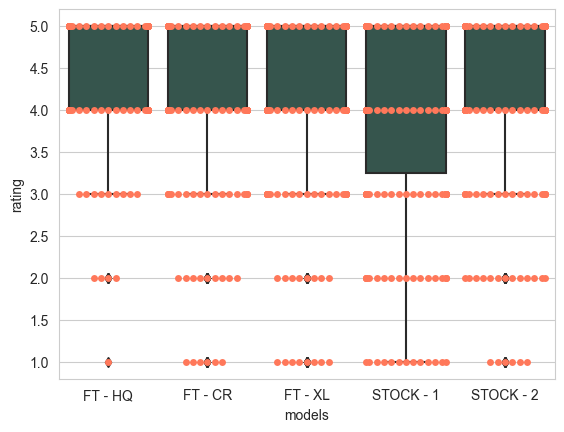

In [16]:
data = {}

for model in all_models:
    data[model] = similarity_scores[model]['HUMAN'][0:230]

df = pd.DataFrame({key: pd.Series(value) for key, value in data.items()})
df_melt = pd.melt(df.reset_index(), id_vars=['index'],
                  value_vars=['FT - HQ', 'FT - CR', 'FT - XL', 'STOCK - 1', 'STOCK - 2'])

# replace column names
df_melt.columns = ['index', 'models', 'rating']

# generate a boxplot to see the data distribution by treatments. Using boxplot, we can
# easily detect the differences between different treatments
import matplotlib.pyplot as plt
import seaborn as sns

ax = sns.boxplot(x='models', y='rating', data=df_melt, color='#315A4F')
ax = sns.swarmplot(x="models", y="rating", data=df_melt, color='#FF785A')
plt.show()

In [17]:
import scipy.stats as stats

fvalue, pvalue = stats.f_oneway(df['FT - HQ'], df['FT - CR'], df['FT - XL'], df['STOCK - 1'], df['STOCK - 2'])
print(fvalue, pvalue)

# get ANOVA table as R like output
import statsmodels.api as sm
from statsmodels.formula.api import ols

# Ordinary Least Squares (OLS) model
model = ols('rating ~ C(models)', data=df_melt).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
display(anova_table)
#print(anova_table.to_latex())

8.644460297530724 7.122671425251642e-07


,sum_sq,df,F,PR(>F)
C(models),34.509565,4.0,8.64446,7.122671e-07
Residual,1142.739130,1145.0,NaN,NaN


### Tukey HSD

In [18]:
tukey = pairwise_tukeyhsd(endog=df_melt['rating'],
                          groups=df_melt['models'],
                          alpha=0.05)
print(tukey)


   Multiple Comparison of Means - Tukey HSD, FWER=0.05    
  group1    group2  meandiff p-adj   lower   upper  reject
----------------------------------------------------------
  FT - CR   FT - HQ   0.2217 0.1214 -0.0328  0.4763  False
  FT - CR   FT - XL  -0.0957  0.843 -0.3502  0.1589  False
  FT - CR STOCK - 1  -0.3174 0.0061 -0.5719 -0.0629   True
  FT - CR STOCK - 2  -0.0348 0.9959 -0.2893  0.2197  False
  FT - HQ   FT - XL  -0.3174 0.0061 -0.5719 -0.0629   True
  FT - HQ STOCK - 1  -0.5391    0.0 -0.7937 -0.2846   True
  FT - HQ STOCK - 2  -0.2565 0.0471  -0.511  -0.002   True
  FT - XL STOCK - 1  -0.2217 0.1214 -0.4763  0.0328  False
  FT - XL STOCK - 2   0.0609  0.966 -0.1937  0.3154  False
STOCK - 1 STOCK - 2   0.2826 0.0208  0.0281  0.5371   True
----------------------------------------------------------


### Detailed Evaluation

In [19]:
dict = {'Model': [],
        '1': [],
        '2': [],
        '3': [],
        '4': [],
        '5': [],
        '6': []}

for model in all_models:
    dict['Model'].append(model)
    dict['1'].append(
        str(round(detailed_ratings_per_model[model].count(1) / len(detailed_ratings_per_model[model]) * 100, 2)) + " %")
    dict['2'].append(
        str(round(detailed_ratings_per_model[model].count(2) / len(detailed_ratings_per_model[model]) * 100, 2)) + " %")
    dict['3'].append(
        str(round(detailed_ratings_per_model[model].count(3) / len(detailed_ratings_per_model[model]) * 100, 2)) + " %")
    dict['4'].append(
        str(round(detailed_ratings_per_model[model].count(4) / len(detailed_ratings_per_model[model]) * 100, 2)) + " %")
    dict['5'].append(
        str(round(detailed_ratings_per_model[model].count(5) / len(detailed_ratings_per_model[model]) * 100, 2)) + " %")
    dict['6'].append(
        str(round(detailed_ratings_per_model[model].count(6) / len(detailed_ratings_per_model[model]) * 100, 2)) + " %")

df = pd.DataFrame(dict)

# displaying the DataFrame
display(df.T)
#print(df.T.to_latex())

,0,1,2,3,4
Model,FT - HQ,FT - CR,FT - XL,STOCK - 1,STOCK - 2
1,37.31 %,28.26 %,34.65 %,17.39 %,45.24 %
2,29.85 %,10.87 %,25.74 %,8.7 %,16.67 %
3,14.93 %,8.7 %,11.88 %,9.57 %,4.76 %
4,8.96 %,33.7 %,11.88 %,42.61 %,15.48 %
5,7.46 %,13.04 %,9.9 %,14.78 %,15.48 %
6,1.49 %,5.43 %,5.94 %,6.96 %,2.38 %


## Automatic Evaluation

In [36]:
data = similarity_scores
dict = {'Model': [],
        'BERT': [],
        'FUZZ': [],
        'JARO': [],
        'BLEU': [],
        'METEOR': [],
        'ROUGE': [],
        'SPACY': [],
        'HUMAN (Punished)': [],
        'HUMAN': []}

for model in all_models:
    dict['Model'].append(model)
    dict['BERT'].append(round(statistics.mean(similarity_scores[model]['BERT']), 4))
    dict['FUZZ'].append(round(statistics.mean(similarity_scores[model]['FUZZ']), 4))
    dict['JARO'].append(round(statistics.mean(similarity_scores[model]['JARO']), 4))
    dict['BLEU'].append(round(statistics.mean(similarity_scores[model]['BLEU']), 4))
    dict['METEOR'].append(round(statistics.mean(similarity_scores[model]['METEOR']), 4))
    dict['ROUGE'].append(round(statistics.mean(similarity_scores[model]['ROUGE']), 4))
    dict['SPACY'].append(round(statistics.mean(similarity_scores[model]['SPACY']), 4))
    dict['HUMAN (Punished)'].append(round(statistics.mean(similarity_scores[model]['HUMAN (Punished)']), 4))
    dict['HUMAN'].append(round(statistics.mean(similarity_scores[model]['HUMAN']), 4))

df = pd.DataFrame(dict)

# displaying the DataFrame
display(df.T)
#print(df.T.to_latex().replace("00", ""))

,0,1,2,3,4
Model,FT - HQ,FT - CR,FT - XL,STOCK - 1,STOCK - 2
BERT,0.7278,0.6722,0.6917,0.6327,0.7268
FUZZ,0.6255,0.4965,0.601,0.4688,0.6219
JARO,0.6848,0.6412,0.6769,0.6308,0.6849
BLEU,0.3187,0.2221,0.3084,0.188,0.3371
METEOR,0.3254,0.2539,0.3113,0.2199,0.3428
ROUGE,0.4621,0.3868,0.4655,0.3434,0.4745
SPACY,0.7589,0.7835,0.7794,0.7666,0.7845
HUMAN (Punished),4.4337,3.9926,4.0389,3.5554,4.153
HUMAN,4.6217,4.3868,4.3017,4.0913,4.3691


### Standard Deviation

In [21]:
data = similarity_scores
dict = {'Model': [],
        'BERT': [],
        'FUZZ': [],
        'JARO': [],
        'BLEU': [],
        'METEOR': [],
        'ROUGE': [],
        'SPACY': [],
        'Human (Adj.)': [],
        'Human': []}

for model in all_models:
    dict['Model'].append(model)
    dict['BERT'].append(round(statistics.stdev(similarity_scores[model]['BERT']), 4))
    dict['FUZZ'].append(round(statistics.stdev(similarity_scores[model]['FUZZ']), 4))
    dict['JARO'].append(round(statistics.stdev(similarity_scores[model]['JARO']), 4))
    dict['BLEU'].append(round(statistics.stdev(similarity_scores[model]['BLEU']), 4))
    dict['METEOR'].append(round(statistics.stdev(similarity_scores[model]['METEOR']), 4))
    dict['ROUGE'].append(round(statistics.stdev(similarity_scores[model]['ROUGE']), 4))
    dict['SPACY'].append(round(statistics.stdev(similarity_scores[model]['SPACY']), 4))
    dict['Human (Adj.)'].append(round(statistics.stdev(similarity_scores[model]['HUMAN (Punished)']), 4))
    dict['Human'].append(round(statistics.stdev(similarity_scores[model]['HUMAN']), 4))

df = pd.DataFrame(dict)

# displaying the DataFrame
display(df)
#print(df.T.to_latex().replace("00", ""))

,Model,BERT,FUZZ,JARO,BLEU,METEOR,ROUGE,SPACY,Human (Adj.),Human
0,FT - HQ,0.2042,0.1841,0.1097,0.2379,0.2563,0.2563,0.1891,1.0532,0.6870
1,FT - CR,0.1970,0.1869,0.0773,0.2147,0.2072,0.2278,0.1317,1.5117,0.9784
2,FT - XL,0.2035,0.1794,0.0951,0.2395,0.2578,0.2618,0.1669,1.4188,1.0246
3,STOCK - 1,0.2002,0.1633,0.0737,0.1873,0.1820,0.2031,0.1462,1.7435,1.1972
4,STOCK - 2,0.1861,0.1682,0.0917,0.2302,0.2447,0.2284,0.1596,1.4029,1.0219


### Covariance of human and automatic evaluation

In [22]:
def correlation_from_covariance(covariance):
    v = np.sqrt(np.diag(covariance))
    outer_v = np.outer(v, v)
    correlation = covariance / outer_v
    correlation[covariance == 0] = 0
    return correlation

<Axes: >

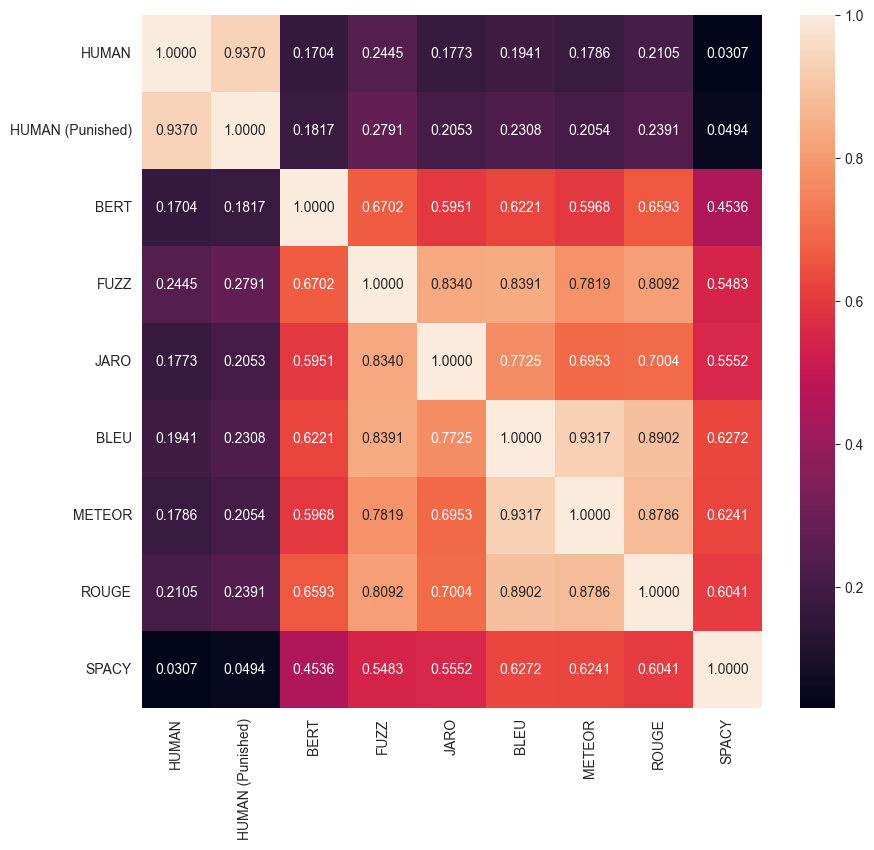

In [23]:
data = similarity_scores_all_models
df = pd.DataFrame(data)
cov_matrix = pd.DataFrame.cov(df.round(2))
corr_matrix = correlation_from_covariance(cov_matrix)
plt.figure(figsize=(10, 9))
sn.heatmap(corr_matrix, annot=True, fmt='.4f')

### Only "Perfect" Ratings


In [24]:
dict = {'Model': [],
        'BERT': [],
        'FUZZ': [],
        'JARO': [],
        'BLEU': [],
        'METEOR': [],
        'ROUGE': [],
        'SPACY': [],
        'HUMAN (Punished)': [],
        'HUMAN': []}

for model in all_models:
    dict['Model'].append(model)
    dict['BERT'].append(round(statistics.mean(similarity_scores_perfect['BERT']), 4))
    dict['FUZZ'].append(round(statistics.mean(similarity_scores_perfect['FUZZ']), 4))
    dict['JARO'].append(round(statistics.mean(similarity_scores_perfect['JARO']), 4))
    dict['BLEU'].append(round(statistics.mean(similarity_scores_perfect['BLEU']), 4))
    dict['METEOR'].append(round(statistics.mean(similarity_scores_perfect['METEOR']), 4))
    dict['ROUGE'].append(round(statistics.mean(similarity_scores_perfect['ROUGE']), 4))
    dict['SPACY'].append(round(statistics.mean(similarity_scores_perfect['SPACY']), 4))
    dict['HUMAN (Punished)'].append(round(statistics.mean(similarity_scores_perfect['HUMAN (Punished)']), 4))
    dict['HUMAN'].append(round(statistics.mean(similarity_scores_perfect['HUMAN']), 4))

df = pd.DataFrame(dict)

# displaying the DataFrame
display(df)
#print(df.T.to_latex().replace("00", ""))

,Model,BERT,FUZZ,JARO,BLEU,METEOR,ROUGE,SPACY,HUMAN (Punished),HUMAN
0,FT - HQ,0.7225,0.6012,0.6792,0.3136,0.3276,0.472,0.7843,5,5
1,FT - CR,0.7225,0.6012,0.6792,0.3136,0.3276,0.472,0.7843,5,5
2,FT - XL,0.7225,0.6012,0.6792,0.3136,0.3276,0.472,0.7843,5,5
3,STOCK - 1,0.7225,0.6012,0.6792,0.3136,0.3276,0.472,0.7843,5,5
4,STOCK - 2,0.7225,0.6012,0.6792,0.3136,0.3276,0.472,0.7843,5,5


#### Standard Deviation

In [25]:
# DEVIATION
dict = {'Model': [],
        'BERT': [],
        'FUZZ': [],
        'JARO': [],
        'BLEU': [],
        'METEOR': [],
        'ROUGE': [],
        'SPACY': [],
        'HUMAN (Punished)': [],
        'HUMAN': []}

for model in all_models:
    dict['Model'].append(model)
    dict['BERT'].append(round(statistics.stdev(similarity_scores_perfect['BERT']), 4))
    dict['FUZZ'].append(round(statistics.stdev(similarity_scores_perfect['FUZZ']), 4))
    dict['JARO'].append(round(statistics.stdev(similarity_scores_perfect['JARO']), 4))
    dict['BLEU'].append(round(statistics.stdev(similarity_scores_perfect['BLEU']), 4))
    dict['METEOR'].append(round(statistics.stdev(similarity_scores_perfect['METEOR']), 4))
    dict['ROUGE'].append(round(statistics.stdev(similarity_scores_perfect['ROUGE']), 4))
    dict['SPACY'].append(round(statistics.stdev(similarity_scores_perfect['SPACY']), 4))
    dict['HUMAN (Punished)'].append(round(statistics.stdev(similarity_scores_perfect['HUMAN (Punished)']), 4))
    dict['HUMAN'].append(round(statistics.stdev(similarity_scores_perfect['HUMAN']), 4))

df = pd.DataFrame(dict)

# displaying the DataFrame
display(df)
#print(df.T.to_latex().replace("00", ""))

,Model,BERT,FUZZ,JARO,BLEU,METEOR,ROUGE,SPACY,HUMAN (Punished),HUMAN
0,FT - HQ,0.1948,0.1882,0.0954,0.2383,0.2455,0.2465,0.16,0.0,0.0
1,FT - CR,0.1948,0.1882,0.0954,0.2383,0.2455,0.2465,0.16,0.0,0.0
2,FT - XL,0.1948,0.1882,0.0954,0.2383,0.2455,0.2465,0.16,0.0,0.0
3,STOCK - 1,0.1948,0.1882,0.0954,0.2383,0.2455,0.2465,0.16,0.0,0.0
4,STOCK - 2,0.1948,0.1882,0.0954,0.2383,0.2455,0.2465,0.16,0.0,0.0


## Keywords in Creation

In [26]:
dict = {'Model': [],
        'Generated (Avg)': [],
        'Generated (Dev)': [],
        'Human Reference (Avg)': [],
        'Human Reference (Dev)': []}

# print(f"\nKeywords in Creation"
#       f"\nAutomatic: {statistics.mean(eval_keywords_in_creation[model]['keywords_in_creation'])}"
#       f"\nHuman: {statistics.mean(eval_keywords_in_creation[model]['keywords_in_creation_human'])}")

for model in all_models:
    dict['Model'].append(model)
    dict['Generated (Avg)'].append(round(statistics.mean(eval_keywords_in_creation[model]['keywords_in_creation']), 4))
    dict['Generated (Dev)'].append(round(statistics.stdev(eval_keywords_in_creation[model]['keywords_in_creation']), 4))
    dict['Human Reference (Avg)'].append(
        round(statistics.mean(eval_keywords_in_creation[model]['keywords_in_creation_human']), 4))
    dict['Human Reference (Dev)'].append(
        round(statistics.stdev(eval_keywords_in_creation[model]['keywords_in_creation_human']), 4))

df = pd.DataFrame(dict)

# displaying the DataFrame

display(df)
# print(df)
#print(df.to_latex().replace("00", ""))

,Model,Generated (Avg),Generated (Dev),Human Reference (Avg),Human Reference (Dev)
0,FT - HQ,0.8807,0.1735,0.8815,0.1805
1,FT - CR,0.8886,0.1801,0.8882,0.1876
2,FT - XL,0.8747,0.1933,0.8746,0.2015
3,STOCK - 1,0.8690,0.1786,0.8698,0.1776
4,STOCK - 2,0.8874,0.1750,0.8895,0.1738


## Length of sentences and creation

In [37]:

dict = {'Model': [],
        'Length Keyword (Avg)': [],
        'Length Generated (Avg)': [],
        'Length Human (Avg)': [],
        'Length Keyword (Dev)': [],
        'Length Generated (Dev)': [],
        'Length Human (Dev)': []}

for model in all_models:
    dict['Model'].append(model)
    dict['Length Generated (Avg)'].append(round(statistics.mean(eval_length[model]['length_created_answer']), 4))
    dict['Length Keyword (Avg)'].append(round(statistics.mean(eval_length[model]['length_keywords']), 4))
    dict['Length Human (Avg)'].append(round(statistics.mean(eval_length[model]['length_human_answer']), 4))
    dict['Length Generated (Dev)'].append(round(statistics.stdev(eval_length[model]['length_created_answer']), 4))
    dict['Length Keyword (Dev)'].append(round(statistics.stdev(eval_length[model]['length_keywords']), 4))
    dict['Length Human (Dev)'].append(round(statistics.stdev(eval_length[model]['length_human_answer']), 4))

df = pd.DataFrame(dict)

display(df.T)
#print(df.T.to_latex().replace("00", ""))


,0,1,2,3,4
Model,FT - HQ,FT - CR,FT - XL,STOCK - 1,STOCK - 2
Length Keyword (Avg),2.5039,2.5091,2.5038,2.634,2.5331
Length Generated (Avg),7.0469,14.36,8.0568,15.5019,8.2568
Length Human (Avg),6.6445,6.8982,6.7955,7.2415,6.8833
Length Keyword (Dev),1.6966,1.1569,1.2209,1.8905,1.2311
Length Generated (Dev),3.205,7.0848,4.0903,7.6994,3.3395
Length Human (Dev),3.4269,3.4962,3.5147,4.3487,3.5699


## Length of history compared to ratings

In [28]:
dict = {'Model': [],
        '2': [],
        '4': [],
        '6': []}

for model in all_models:
    dict['Model'].append(model)
    for rate in different_lengths:
        if rate == '8':
            continue
        dict[rate].append(round(statistics.mean(length_compared_to_scores[model][str(rate)]['HUMAN']), 4))
df = pd.DataFrame(dict)

display(df)
#print(df.to_latex().replace("00", ""))

,Model,2,4,6
0,FT - HQ,4.5070,4.7083,4.6437
1,FT - CR,4.3371,4.4588,4.3529
2,FT - XL,4.4881,4.1358,4.2667
3,STOCK - 1,4.0645,4.0811,4.1351
4,STOCK - 2,4.2769,4.4235,4.3855


### Standard Deviation

In [29]:
dict = {'Model': [],
        '2': [],
        '4': [],
        '6': []}

for model in all_models:
    dict['Model'].append(model)
    for rate in different_lengths:
        if rate == '8':
            continue
        dict[rate].append(round(statistics.stdev(length_compared_to_scores[model][str(rate)]['HUMAN']), 4))
df = pd.DataFrame(dict)

display(df)
#print(df.to_latex().replace("00", ""))

,Model,2,4,6
0,FT - HQ,0.7723,0.6152,0.6643
1,FT - CR,1.0329,0.8668,1.0476
2,FT - XL,0.8430,1.1153,1.0946
3,STOCK - 1,1.1869,1.2470,1.1742
4,STOCK - 2,1.1793,0.8363,1.0688


## Rating compared to amount of keywords

In [30]:
dict = {'Model': [],
        # '0' : [],
        '1': [],
        '2': [],
        '3': [],
        '4': [],
        '5': []}

for model in all_models:
    dict['Model'].append(model)
    for rate in number_of_keywords:
        if rate == "0":
            continue
        if len(rating_compared_to_amount_keywords[model][str(rate)]['HUMAN (Punished)']) == 0:
            continue
        dict[rate].append(round(statistics.mean(rating_compared_to_amount_keywords[model][str(rate)]['HUMAN']), 4))
df1 = pd.DataFrame({key: pd.Series(value) for key, value in dict.items()})

dict = {'Model': [],
        # '0' : [],
        '1': [],
        '2': [],
        '3': [],
        '4': [],
        '5': []}

for model in all_models:
    dict['Model'].append(model)
    for rate in number_of_keywords:
        if rate == "0":
            continue
        if len(rating_compared_to_amount_keywords[model][str(rate)]['HUMAN (Punished)']) == 0:
            continue
        dict[rate].append(round(statistics.stdev(rating_compared_to_amount_keywords[model][str(rate)]['HUMAN']), 4))
df2 = pd.DataFrame({key: pd.Series(value) for key, value in dict.items()})
dict = {'Model': [],
        # '0' : [],
        '1': [],
        '2': [],
        '3': [],
        '4': [],
        '5': []}
for model in all_models:
    dict['Model'].append(model)
    for rate in number_of_keywords:
        if rate == "0":
            continue
        if len(rating_compared_to_amount_keywords[model][str(rate)]['HUMAN (Punished)']) == 0:
            continue
        dict[rate].append(len((rating_compared_to_amount_keywords[model][str(rate)]['HUMAN'])))
df3 = pd.DataFrame({key: pd.Series(value) for key, value in dict.items()})

print("Means")
display(df1)
print("Standard Deviation")
display(df2)
print("Amounts")
display(df3)

#print(df1.to_latex().replace("00", ""))
#print(df2.to_latex().replace("00", ""))
#print(df3.to_latex().replace("00", ""))

Means


,Model,1,2,3,4,5
0,FT - HQ,4.5319,4.7586,4.4912,4.6207,4.6667
1,FT - CR,4.4186,4.4433,4.3273,4.4400,4.1739
2,FT - XL,4.2045,4.4565,4.1875,4.6364,3.8000
3,STOCK - 1,4.2245,4.1932,3.7667,4.1667,4.2000
4,STOCK - 2,4.5000,4.5059,4.3651,3.8077,4.1538


Standard Deviation


,Model,1,2,3,4,5
0,FT - HQ,0.6203,0.5899,0.8686,0.6219,0.7071
1,FT - CR,0.9570,0.9125,1.0725,1.0033,1.0725
2,FT - XL,0.9784,0.9068,1.1391,0.6580,1.3611
3,STOCK - 1,0.9189,1.0706,1.4999,1.2039,1.2397
4,STOCK - 2,0.7817,0.8398,1.1260,1.3272,1.3445


Amounts


,Model,1,2,3,4,5
0,FT - HQ,47,87,57,29,9
1,FT - CR,43,97,55,25,23
2,FT - XL,44,92,64,22,20
3,STOCK - 1,49,88,60,24,20
4,STOCK - 2,46,85,63,26,13


## Runtime

In [31]:
# print(eval_runtime)

dict = {'Model': [],
        'Runtime (Avg)': [],
        'Runtime (Dev)': []}

# Bereinigt
for model in all_models:
    for runtime in eval_runtime[model]:
        if runtime > 100:
            eval_runtime[model].remove(runtime)

for model in all_models:
    dict['Model'].append(model)
    dict['Runtime (Avg)'].append(round(statistics.mean(eval_runtime[model]), 4))
    dict['Runtime (Dev)'].append(round(statistics.stdev(eval_runtime[model]), 4))
df = pd.DataFrame({key: pd.Series(value) for key, value in dict.items()})

display(df)
#print(df.to_latex().replace("00", ""))

,Model,Runtime (Avg),Runtime (Dev)
0,FT - HQ,1.0101,0.5439
1,FT - CR,1.1816,0.6709
2,FT - XL,0.9568,0.5193
3,STOCK - 1,1.2220,0.6747
4,STOCK - 2,0.9204,0.5231


## Rating Compared to scenario

In [32]:

different_scenario_type = ["open",
                           "defined"
                           ]

dict = {'Model': [],
        'open': [],
        'defined': []}

for model in all_models:
    dict['Model'].append(model)
    for rate in different_scenario_type:
        dict[rate].append(round(statistics.mean(rating_compared_scenarios_open_closed[model][str(rate)]['HUMAN']), 4))
df1 = pd.DataFrame({key: pd.Series(value) for key, value in dict.items()})

dict = {'Model': [],
        'open': [],
        'defined': []}

for model in all_models:
    dict['Model'].append(model)
    for rate in different_scenario_type:
        dict[rate].append(round(statistics.stdev(rating_compared_scenarios_open_closed[model][str(rate)]['HUMAN']), 4))
df2 = pd.DataFrame({key: pd.Series(value) for key, value in dict.items()})

print("Means")
display(df1)
print("Standard Deviation")
display(df2)
#print(df1.to_latex().replace("00", ""))
#print(df2.to_latex().replace("00", ""))

Means


,Model,open,defined
0,FT - HQ,4.5652,4.6783
1,FT - CR,4.4123,4.3643
2,FT - XL,4.3197,4.2833
3,STOCK - 1,4.0463,4.1278
4,STOCK - 2,4.3017,4.4359


Standard Deviation


,Model,open,defined
0,FT - HQ,0.7271,0.6427
1,FT - CR,0.9483,1.0073
2,FT - XL,1.0307,1.0223
3,STOCK - 1,1.1791,1.2149
4,STOCK - 2,1.0402,1.0033


In [33]:

dict = {'Model': [],
        '0': [],
        '1': [],
        '2': [],
        '3': [],
        '4': [],
        '5': [],
        '6': [],
        '7': [],
        '8': []}

for model in all_models:
    dict['Model'].append(model)
    for rate in different_scenario_numbers:
        dict[rate].append(round(statistics.mean(rating_compared_scenarios_all[model][str(rate)]['HUMAN']), 4))
df1 = pd.DataFrame({key: pd.Series(value) for key, value in dict.items()})

dict = {'Model': [],
        '0': [],
        '1': [],
        '2': [],
        '3': [],
        '4': [],
        '5': [],
        '6': [],
        '7': [],
        '8': []}

for model in all_models:
    dict['Model'].append(model)
    for rate in different_scenario_numbers:
        dict[rate].append(round(statistics.stdev(rating_compared_scenarios_all[model][str(rate)]['HUMAN']), 4))
df2 = pd.DataFrame({key: pd.Series(value) for key, value in dict.items()})

print("Means")
display(df1)
print("Standard Deviation")
display(df2)
#print(df1.to_latex().replace("00", ""))
#print(df2.to_latex().replace("00", ""))


Means


,Model,0,1,2,3,4,5,6,7,8
0,FT - HQ,NaN,4.7200,4.6207,4.7500,4.6757,4.4800,4.6667,4.7083,4.4359
1,FT - CR,NaN,4.6071,4.4483,4.5000,4.3659,4.5517,4.2759,4.0645,4.3438
2,FT - XL,NaN,4.4062,4.1379,4.2424,4.3667,4.3333,4.4828,4.2069,4.2424
3,STOCK - 1,NaN,4.0278,4.2759,3.9688,4.0769,4.2222,4.0556,4.1724,3.9677
4,STOCK - 2,NaN,4.2500,4.5946,4.2143,4.3000,4.3913,4.3636,4.5000,4.2500


Standard Deviation


,Model,0,1,2,3,4,5,6,7,8
0,FT - HQ,NaN,0.5416,0.7277,0.5316,0.6689,1.0050,0.5547,0.6241,0.7180
1,FT - CR,NaN,0.6289,0.8696,0.8341,1.1781,0.9851,0.8408,1.1236,1.0957
2,FT - XL,NaN,0.9791,1.0930,1.0906,0.8899,1.0000,0.9495,1.1458,1.0906
3,STOCK - 1,NaN,1.2532,1.0986,1.1496,1.2223,1.1547,1.3921,1.3112,1.1397
4,STOCK - 2,NaN,1.0195,0.8320,1.1007,1.1788,0.9881,1.0553,1.0086,1.0473


## Keyword tools

In [34]:
mean_counter = {
    "KeyBERT": [],
    "YAKE": [],
    "YAKE (Detailed)": [],
    "HUMAN": []
}

for keyword_method in all_keyword_methods:
    for classifiers in all_classifiers:
        mean_counter[keyword_method].append(statistics.mean(keywords_eval[keyword_method][classifiers]))

dict = {'Model': [],
        'score_created_in_given': [],
        'score_given_in_created': [],
        'score_classifier_created_given': [],
        'score_classifier_given_created': [],
        'BERT': [],
        'FUZZ': [],
        'JARO': [],
        'BLEU': [],
        'METEOR': [],
        'ROUGE': [],
        'SPACY': [],
        'Average': []
        }

for keyword_method in all_keyword_methods:
    dict['Model'].append(keyword_method)
    for classifiers in all_classifiers:
        dict[classifiers].append(round(statistics.mean(keywords_eval[keyword_method][classifiers]), 4))
    dict['Average'].append(round(statistics.mean(mean_counter[keyword_method]), 4))
df = pd.DataFrame({key: pd.Series(value) for key, value in dict.items()})

display(df.T)
#print(df.T.to_latex().replace("00", ""))

,0,1,2,3
Model,KeyBERT,YAKE,YAKE (Detailed),HUMAN
score_created_in_given,0.6541,0.686,0.5896,1.0
score_given_in_created,0.7355,0.6547,0.6175,1.0
score_classifier_created_given,0.858,0.7918,0.7514,0.9923
score_classifier_given_created,0.8583,0.8012,0.8083,0.9923
BERT,0.7772,0.7495,0.7227,1.0
FUZZ,0.7228,0.5574,0.6297,1.0
JARO,0.7404,0.6243,0.6713,1.0
BLEU,0.5673,0.5475,0.4593,1.0
METEOR,0.5547,0.4049,0.4139,0.8735


### Standard Deviation

In [35]:
mean_counter = {
    "KeyBERT": [],
    "YAKE": [],
    "YAKE (Detailed)": [],
    "HUMAN": []
}

for keyword_method in all_keyword_methods:
    for classifiers in all_classifiers:
        mean_counter[keyword_method].append(statistics.mean(keywords_eval[keyword_method][classifiers]))

dict = {'Model': [],
        'score_created_in_given': [],
        'score_given_in_created': [],
        'score_classifier_created_given': [],
        'score_classifier_given_created': [],
        'BERT': [],
        'FUZZ': [],
        'JARO': [],
        'BLEU': [],
        'METEOR': [],
        'ROUGE': [],
        'SPACY': [],
        'Average': []
        }

for keyword_method in all_keyword_methods:
    dict['Model'].append(keyword_method)
    for classifiers in all_classifiers:
        dict[classifiers].append(round(statistics.stdev(keywords_eval[keyword_method][classifiers]), 4))
    dict['Average'].append(round(statistics.stdev(mean_counter[keyword_method]), 4))
df = pd.DataFrame({key: pd.Series(value) for key, value in dict.items()})

display(df.T)
#print(df.T.to_latex().replace("00", ""))

,0,1,2,3
Model,KeyBERT,YAKE,YAKE (Detailed),HUMAN
score_created_in_given,0.3202,0.3637,0.3572,0.0
score_given_in_created,0.3235,0.3537,0.3692,0.0
score_classifier_created_given,0.2926,0.3544,0.3651,0.0427
score_classifier_given_created,0.2673,0.3361,0.3352,0.0427
BERT,0.2119,0.2336,0.2452,0.0
FUZZ,0.2328,0.2515,0.2886,0.0
JARO,0.238,0.2664,0.2867,0.0
BLEU,0.3038,0.34,0.3159,0.0
METEOR,0.3161,0.2587,0.2941,0.1849
